# Converting .ipynb file into pdf

### Mount drive

In [ ]:
import sys
from google.colab import drive

#mount google drive
drive.mount('/content/drive/')

#update the system path so that Python knows to look in this folder for libraries
sys.path.append('/content/drive/My Drive')

### Installing latex libraries and converting to pdf

In [ ]:
%cd My\Drive/Colab\ Notebooks

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

In [ ]:
!jupyter nbconvert --to pdf 'Advanced NLE Assignment Language Models.ipynb'

[NbConvertApp] Converting notebook Advanced NLE Assignment Language Models.ipynb to pdf
[NbConvertApp] Support files will be in Advanced NLE Assignment Language Models_files/
[NbConvertApp] Making directory ./Advanced NLE Assignment Language Models_files
[NbConvertApp] Making directory ./Advanced NLE Assignment Language Models_files
[NbConvertApp] Writing 376252 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 282890 bytes to Advanced NLE Assignment Language Models.pdf


# Useful packages & Set Training/Testing Files


### Import packages

In [ ]:
import os
import pandas as pd, csv
import random
import numpy as np
import math
import operator
from collections import Counter
import matplotlib.pyplot as plt

#For LSTM model
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)


#For Word Similarity in Distributional smoothing
import gensim
from gensim.models import Word2Vec

#For word tokenization
import nltk
nltk.download('punkt')

from nltk import word_tokenize as tokenize

### Train test split

In [ ]:
#Get all of the training files from Homes_Training data for sentence completion
def get_training_files(training_dir,split=1):
  filenames=os.listdir(training_dir)
  print("There are {} files in the training directory: {}".format(len(filenames),training_dir))
  random.shuffle(filenames)
  return filenames

parentdir="/content/drive/My Drive/lab2resources/lab2resources/sentence-completion"  #'C:/Users/benat/Documents/sentence-completion'   Please enter your training data path
trainingdir=os.path.join(parentdir,"Holmes_Training_Data")

training = get_training_files(trainingdir)

# Visualise the challenge & Create Sentence Completion Challenge Reader


In [ ]:
pd.options.display.max_colwidth = 500
questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

#Visualise the sentences and their possibilities 
with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])

#Visualise the answers to complete the sentence
with open(answers) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_df["answers"] = lines[1:]
qs_df.head()


,id,question,a),b),c),d),e),answers
0,1,I have it from the same source that you are both an orphan and a bachelor and are _____ alone in London.,crying,instantaneously,residing,matched,walking,"[1, c]"
1,2,"It was furnished partly as a sitting and partly as a bedroom , with flowers arranged _____ in every nook and corner.",daintily,privately,inadvertently,miserably,comfortably,"[2, a]"
2,3,"As I descended , my old ally , the _____ , came out of the room and closed the door tightly behind him.",gods,moon,panther,guard,country-dance,"[3, d]"
3,4,"We got off , _____ our fare , and the trap rattled back on its way to Leatherhead.",rubbing,doubling,paid,naming,carrying,"[4, c]"
4,5,"He held in his hand a _____ of blue paper , scrawled over with notes and figures.",supply,parcel,sign,sheet,chorus,"[5, d]"


In [ ]:
class question:

    def __init__(self,aline):
      #Process sentence
      self.fields=aline

    def get_tokens(self):
      #Seperate sentence into tokens
      return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]

    def get_field(self,field):
      #Get the the field from the possible words to complete the sentence
      #Can be a), b), c), d) or e)
      return self.fields[question.colnames[field]]
    
    def add_answer(self,fields):
      #Get correct option
      self.answer=fields[1]
   
    def chooseA(self):
      #Always choose first possible word
      return("a")

    def chooseunigram(self,lm):
      #Method which uses the unigram language model
      choices=["a","b","c","d","e"]      
      probs=[lm.unigram.get(self.get_field(ch+")"),0) for ch in choices]  #Get probability from dictionary (unigram) value from each possible word
      maxprob=max(probs)
      bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
      return np.random.choice(bestchoices)  #If multiple best options, choose randomly

    def get_left_context(self,window=1,target="_____"):
      #Get the left context from the target word
      found=-1
      sent_tokens=self.get_tokens()
      for i,token in enumerate(sent_tokens):
          if token==target:
              found=i
              break          
      if found>-1:
          return sent_tokens[i-window:i]
      else:
          return []
        
    def choosebigram(self,lm,method="bigram",choices=[]):
      #Method which uses the bigram language model
      if choices==[]:
          choices=["a","b","c","d","e"]
      context=self.get_left_context(window=1)
      probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method}) for ch in choices]  #Get probability from language model which uses Discount smoothing
      maxprob=max(probs)
      bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
      return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
      #Get the predicted word option
      if method=="chooseA":
          return self.chooseA()
      elif method=="random":
          return self.chooserandom()
      elif method=="unigram":
          return self.chooseunigram(lm=lm)
      elif method=="bigram":
          return self.choosebigram(lm=lm)
        
    def predict_and_score(self,method,lm):
      #compare prediction according to method with the correct answer
      #return 1 or 0 accordingly
      prediction=self.predict(method=method,lm=lm)
      if prediction ==self.answer:
          return 1
      else:
          return 0

class scc_reader:
    
    def __init__(self,qs=questions,ans=answers):
        self.qs=qs
        self.ans=ans
        self.read_files()
        
    def read_files(self):
        #read in the question file
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            qlines=list(csvreader)
        
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames={item:i for i,item in enumerate(qlines[0])}
        
        #create a question instance for each line of the file (other than heading line)
        self.questions=[question(qline) for qline in qlines[1:]]
        
        #read in the answer file
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
            
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):
            q.add_answer(aline)
        
    def get_field(self,field):
      #Get field a), b), c) or d) from word possibilities
      return [q.get_field(field) for q in self.questions] 
    
    def predict(self,method,lm):
      #Get predicted word option
      return [q.predict(method=method,lm=lm) for q in self.questions]
    
    def predict_and_score(self,method,lm):
        #Used to predict model accuracy
        scores=[q.predict_and_score(method=method,lm=lm) for q in self.questions]
        return sum(scores)/len(scores)

In [ ]:
#Check if the reader is working
SCC = scc_reader()
print(SCC.get_field("a)")[:4])
print(SCC.predict(method="chooseA",lm=None)[:4])
SCC.predict_and_score(method="chooseA",lm=None)

['crying', 'daintily', 'gods', 'rubbing']
['a', 'a', 'a', 'a']


0.19903846153846153

# Language models

In [ ]:
class language_model():
    def __init__(self,trainingdir=parentdir,files=[]):
        self.training_dir=trainingdir
        self.files=files
        self.train()    
        
    def train(self):
        self.unigram={}
        self.bigram={}

        self.start = False  #Starting point of when to get tokens from training data
        self.end_tags = ["End of Project Gutenberg's Etext", "End of Project Gutenberg Etext", "End of the Project Gutenberg Etext", "End of the Project Gutenberg eText"]  #End mark for metadata
        self._processfiles()

        self._make_unknowns()
        self._discount()
        self._kneser_ney()

        self._convert_to_probs()
        
    
    def _processline(self,line):
      #Process each line in the file
      #Only process sentence if sentence is not in the metadata
      if "end of project gutenberg" not in line.lower() and "end of the project gutenberg" not in line.lower():
        tokens=["__START"]+tokenize(line)+["__END"] #Add Start and End padding to tokenized sentence
        previous="__END"
        for token in tokens:
            self.unigram[token]=self.unigram.get(token,0)+1
            current=self.bigram.get(previous,{})
            current[token]=current.get(token,0)+1
            self.bigram[previous]=current
            previous=token
            
    
    def _processfiles(self, remove_metadata=True):
      if remove_metadata:
        #Process each file
        for afile in self.files:
          print("Processing {}".format(afile))
          try:
              with open(os.path.join(self.training_dir,afile)) as instream:
                  for line in instream:
                      line=line.rstrip()
                      if len(line)>0 and self.start:
                          self._processline(line)
                      if "*END*" in line:
                        self.start = True
                  self.start = False
          except UnicodeDecodeError:
              print("UnicodeDecodeError processing {}: ignoring file".format(afile))
      else:
        for file in training[:1]:
          print("Processing {}".format(file))
          try: 
            with open(os.path.join(trainingdir,file)) as instream:
              for line in instream:
                line=line.rstrip()
                if len(line)>0:
                  tokens=["__START"]+tokenize(line)+["__END"] #Add Start and End padding to tokenized sentence
                  previous="__END"
                  for token in tokens:
                    self.unigram[token]=self.unigram.get(token,0)+1
                    current=self.bigram.get(previous,{})
                    current[token]=current.get(token,0)+1
                    self.bigram[previous]=current
                    previous=token
          except UnicodeDecodeError:
            print("UnicodeDecodeError processing {}: ignoring file".format(file))

      
            
    def _convert_to_probs(self):
      #To get the probabilities, divide frequency of a certain word and divided by all occurring words
      self.unigram={k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
      self.bigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
      self.kn={k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}
        
      ###adjust __UNK probabilities to include probability of an individual unknown word (1/number_unknowns) 
      self.unigram["__UNK"]=self.unigram.get("__UNK",0)/self.number_unknowns
      self.bigram["__UNK"]={k:v/self.number_unknowns for (k,v) in self.bigram.get("__UNK",{}).items()}
      for key,adict in self.bigram.items():
          adict["__UNK"]=adict.get("__UNK",0)/self.number_unknowns
          self.bigram[key]=adict
      self.kn["__UNK"]=self.kn.get("__UNK",0)/self.number_unknowns
    
        
    def get_prob(self,token,context="",methodparams={}):
      #Get probability from unigram/bigram, plus add some smoothing
      if methodparams.get("method","unigram")=="unigram":
          return self.unigram.get(token,self.unigram.get("__UNK",0))
      else:
          if methodparams.get("smoothing","kneser-ney")=="kneser-ney":
              unidist=self.kn
          else:
              unidist=self.unigram
          bigram=self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
          big_p=bigram.get(token,bigram.get("__UNK",0))
          lmbda=bigram["__DISCOUNT"]
          uni_p=unidist.get(token,unidist.get("__UNK",0))
          p=big_p+lmbda*uni_p            
          return p
    
    
    def nextlikely(self,k=1,current="",method="unigram"):
        #use probabilities according to method to generate a likely next sequence
        #choose random token from k best
        blacklist=["__START","__UNK","__DISCOUNT"]
       
        if method=="unigram":
            dist=self.unigram
        else:
            dist=self.bigram.get(current,self.bigram.get("__UNK",{}))
    
        #sort the tokens by unigram probability
        mostlikely=sorted(list(dist.items()),key=operator.itemgetter(1),reverse=True)
        #filter out any undesirable tokens
        filtered=[w for (w,p) in mostlikely if w not in blacklist]
        #choose one randomly from the top k
        res=random.choice(filtered[:k])
        return res
    
    def generate(self,k=1,end="__END",limit=20,method="bigram",methodparams={}):
      #Generate a sentence
        if method=="":
            method=methodparams.get("method","bigram")
        current="__START"
        tokens=[]
        while current!=end and len(tokens)<limit:
            current=self.nextlikely(k=k,current=current,method=method)
            tokens.append(current)
        return " ".join(tokens[:-1])
    
    
    def compute_prob_line(self,line,methodparams={}):
        #this will add _start to the beginning of a line of text
        #compute the probability of the line according to the desired model
        #and returns probability together with number of tokens
        
        tokens=["__START"]+tokenize(line)+["__END"]
        acc=0
        for i,token in enumerate(tokens[1:]):
            acc+=math.log(self.get_prob(token,tokens[:i+1],methodparams))
        return acc,len(tokens[1:])
    
    def compute_probability(self,filenames=[],methodparams={}):
        #computes the probability (and length) of a corpus contained in filenames
        if filenames==[]:
            filenames=self.files
        
        total_p=0
        total_N=0
        for i,afile in enumerate(filenames):
            print("Processing file {}:{}".format(i,afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            p,N=self.compute_prob_line(line,methodparams=methodparams)
                            total_p+=p
                            total_N+=N
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
        return total_p,total_N
    
    def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
        
        #compute the probability and length of the corpus
        #calculate perplexity
        #lower perplexity means that the model better explains the data
        
        p,N=self.compute_probability(filenames=filenames,methodparams=methodparams)
        #print(p,N)
        pp=math.exp(-p/N)
        return pp  
    
    def _make_unknowns(self,known=100):
      #Convert least occuring words in the language models into Out-Of-Vocabulary "__UNK" tokens
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):  #In unigrams do for each key
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1
        for (k,adict) in list(self.bigram.items()): #In bigrams do for each key and nested key
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
                
            else:
                self.bigram[k]=adict
                
    def _discount(self,discount=0.75):
        #discount each bigram count by a small fixed amount
        self.bigram={k:{kk:value-discount for (kk,value) in adict.items()}for (k,adict) in self.bigram.items()}
        
        #for each word, store the total amount of the discount so that the total is the same 
        #i.e., so we are reserving this as probability mass
        for k in self.bigram.keys():
            lamb=len(self.bigram[k])
            self.bigram[k]["__DISCOUNT"]=lamb*discount
               
    def _kneser_ney(self):
        #work out kneser-ney unigram probabilities
        #count the number of contexts each word has been seen in
        self.kn={}
        for (k,adict) in self.bigram.items():
            for kk in adict.keys():
                self.kn[kk]=self.kn.get(kk,0)+1

In [ ]:
lm = language_model(trainingdir=trainingdir,files=training)

### Unigram & Bigram models

###Scores

In [ ]:
def get_left_context(sent_tokens,window,target="_____"):
    found=-1
    for i,token in enumerate(sent_tokens):
        if token==target:
            found=i
            break 
            
    if found>-1:
        return sent_tokens[i-window:i]
    else:
        return []
    

qs_df['tokens']=qs_df['question'].map(tokenize)
qs_df['left_context']=qs_df['tokens'].map(lambda x: get_left_context(x,2))

In [ ]:
#Check if it is working
SCC_unigram = scc_reader()
SCC_bigram = scc_reader()

uni_average = []
bi_average = []
for i in range(10):
  acc = SCC_unigram.predict_and_score(method="unigram",lm=lm)
  uni_average.append(acc)

  acc = SCC_bigram.predict_and_score(method="bigram",lm=lm)
  bi_average.append(acc)  

print("Score for unigram",sum(uni_average)/len(uni_average))
print("Score for bigram",sum(bi_average)/len(bi_average))

qs_df["bigram_pred"]=SCC.predict(method="bigram",lm=lm)
qs_df["unigram_pred"]=SCC.predict(method="unigram",lm=lm)
qs_df[:5]

Score for unigram 0.20798076923076922
Score for bigram 0.2021153846153846


,id,question,a),b),c),d),e),answers,tokens,left_context,bigram_pred,unigram_pred
0,1,I have it from the same source that you are both an orphan and a bachelor and are _____ alone in London.,crying,instantaneously,residing,matched,walking,"[1, c]","[I, have, it, from, the, same, source, that, you, are, both, an, orphan, and, a, bachelor, and, are, _____, alone, in, London, .]","[and, are]",a,c
1,2,"It was furnished partly as a sitting and partly as a bedroom , with flowers arranged _____ in every nook and corner.",daintily,privately,inadvertently,miserably,comfortably,"[2, a]","[It, was, furnished, partly, as, a, sitting, and, partly, as, a, bedroom, ,, with, flowers, arranged, _____, in, every, nook, and, corner, .]","[flowers, arranged]",c,d
2,3,"As I descended , my old ally , the _____ , came out of the room and closed the door tightly behind him.",gods,moon,panther,guard,country-dance,"[3, d]","[As, I, descended, ,, my, old, ally, ,, the, _____, ,, came, out, of, the, room, and, closed, the, door, tightly, behind, him, .]","[,, the]",e,d
3,4,"We got off , _____ our fare , and the trap rattled back on its way to Leatherhead.",rubbing,doubling,paid,naming,carrying,"[4, c]","[We, got, off, ,, _____, our, fare, ,, and, the, trap, rattled, back, on, its, way, to, Leatherhead, .]","[off, ,]",b,c
4,5,"He held in his hand a _____ of blue paper , scrawled over with notes and figures.",supply,parcel,sign,sheet,chorus,"[5, d]","[He, held, in, his, hand, a, _____, of, blue, paper, ,, scrawled, over, with, notes, and, figures, .]","[hand, a]",e,a


##### Metadata probability

Training without metadata

In [ ]:
sort_orders = sorted(lm.bigram.get("public").items(), key=lambda x: x[1], reverse=True)
sort_orders[:3]

[('__DISCOUNT', 0.22330097087378642),
 ('__END', 0.08940129449838188),
 (',', 0.06351132686084142)]

Training with metadata

In [ ]:
class language_model():
    def __init__(self,trainingdir=parentdir,files=[]):
        self.training_dir=trainingdir
        self.files=files
        self.train()    
        
    def train(self):
        self.unigram={}
        self.bigram={}

        self.start = False  #Starting point of when to get tokens from training data
        self.end_tags = ["End of Project Gutenberg's Etext", "End of Project Gutenberg Etext", "End of the Project Gutenberg Etext", "End of the Project Gutenberg eText"]  #End mark for metadata
        self._processfiles()

        self._make_unknowns()
        self._discount()
        self._kneser_ney()

        self._convert_to_probs()
        
    
    def _processline(self,line):
      #Process each line in the file
      #Only process sentence if sentence is not in the metadata
      if "end of project gutenberg" not in line.lower() and "end of the project gutenberg" not in line.lower():
        tokens=["__START"]+tokenize(line)+["__END"] #Add Start and End padding to tokenized sentence
        previous="__END"
        for token in tokens:
            self.unigram[token]=self.unigram.get(token,0)+1
            current=self.bigram.get(previous,{})
            current[token]=current.get(token,0)+1
            self.bigram[previous]=current
            previous=token
            
    
    def _processfiles(self, remove_metadata=False):
      if remove_metadata:
        #Process each file
        for afile in self.files:
          print("Processing {}".format(afile))
          try:
              with open(os.path.join(self.training_dir,afile)) as instream:
                  for line in instream:
                      line=line.rstrip()
                      if len(line)>0 and self.start:
                          self._processline(line)
                      if "*END*" in line:
                        self.start = True
                  self.start = False
          except UnicodeDecodeError:
              print("UnicodeDecodeError processing {}: ignoring file".format(afile))
      else:
        for afile in self.files:
          print("Processing {}".format(afile))
          try: 
            with open(os.path.join(self.training_dir,afile)) as instream:
              for line in instream:
                line=line.rstrip()
                if len(line)>0:
                  tokens=["__START"]+tokenize(line)+["__END"] #Add Start and End padding to tokenized sentence
                  previous="__END"
                  for token in tokens:
                    self.unigram[token]=self.unigram.get(token,0)+1
                    current=self.bigram.get(previous,{})
                    current[token]=current.get(token,0)+1
                    self.bigram[previous]=current
                    previous=token
          except UnicodeDecodeError:
            print("UnicodeDecodeError processing {}: ignoring file".format(file))

      
            
    def _convert_to_probs(self):
      #To get the probabilities, divide frequency of a certain word and divided by all occurring words
      self.unigram={k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
      self.bigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
      self.kn={k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}
        
      ###adjust __UNK probabilities to include probability of an individual unknown word (1/number_unknowns) 
      self.unigram["__UNK"]=self.unigram.get("__UNK",0)/self.number_unknowns
      self.bigram["__UNK"]={k:v/self.number_unknowns for (k,v) in self.bigram.get("__UNK",{}).items()}
      for key,adict in self.bigram.items():
          adict["__UNK"]=adict.get("__UNK",0)/self.number_unknowns
          self.bigram[key]=adict
      self.kn["__UNK"]=self.kn.get("__UNK",0)/self.number_unknowns
    
        
    def get_prob(self,token,context="",methodparams={}):
      #Get probability from unigram/bigram, plus add some smoothing
      if methodparams.get("method","unigram")=="unigram":
          return self.unigram.get(token,self.unigram.get("__UNK",0))
      else:
          if methodparams.get("smoothing","kneser-ney")=="kneser-ney":
              unidist=self.kn
          else:
              unidist=self.unigram
          bigram=self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
          big_p=bigram.get(token,bigram.get("__UNK",0))
          lmbda=bigram["__DISCOUNT"]
          uni_p=unidist.get(token,unidist.get("__UNK",0))
          p=big_p+lmbda*uni_p            
          return p
    
    
    def nextlikely(self,k=10,current="",method="unigram"):
        #use probabilities according to method to generate a likely next sequence
        #choose random token from k best
        blacklist=["__START","__UNK","__DISCOUNT"]
       
        if method=="unigram":
            dist=self.unigram
        else:
            dist=self.bigram.get(current,self.bigram.get("__UNK",{}))
    
        #sort the tokens by unigram probability
        mostlikely=sorted(list(dist.items()),key=operator.itemgetter(1),reverse=True)
        #filter out any undesirable tokens
        filtered=[w for (w,p) in mostlikely if w not in blacklist]
        #choose one randomly from the top k
        res=random.choice(filtered[:k])
        return res
    
    def generate(self,k=1,end="__END",limit=20,method="bigram",methodparams={}):
      #Generate a sentence
        if method=="":
            method=methodparams.get("method","bigram")
        current="__START"
        tokens=[]
        while current!=end and len(tokens)<limit:
            current=self.nextlikely(k=k,current=current,method=method)
            tokens.append(current)
        return " ".join(tokens[:-1])
    
    
    def compute_prob_line(self,line,methodparams={}):
        #this will add _start to the beginning of a line of text
        #compute the probability of the line according to the desired model
        #and returns probability together with number of tokens
        
        tokens=["__START"]+tokenize(line)+["__END"]
        acc=0
        for i,token in enumerate(tokens[1:]):
            acc+=math.log(self.get_prob(token,tokens[:i+1],methodparams))
        return acc,len(tokens[1:])
    
    def compute_probability(self,filenames=[],methodparams={}):
        #computes the probability (and length) of a corpus contained in filenames
        if filenames==[]:
            filenames=self.files
        
        total_p=0
        total_N=0
        for i,afile in enumerate(filenames):
            print("Processing file {}:{}".format(i,afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            p,N=self.compute_prob_line(line,methodparams=methodparams)
                            total_p+=p
                            total_N+=N
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
        return total_p,total_N
    
    def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
        
        #compute the probability and length of the corpus
        #calculate perplexity
        #lower perplexity means that the model better explains the data
        
        p,N=self.compute_probability(filenames=filenames,methodparams=methodparams)
        #print(p,N)
        pp=math.exp(-p/N)
        return pp  
    
    def _make_unknowns(self,known=100):
      #Convert least occuring words in the language models into Out-Of-Vocabulary "__UNK" tokens
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):  #In unigrams do for each key
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1
        for (k,adict) in list(self.bigram.items()): #In bigrams do for each key and nested key
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
                
            else:
                self.bigram[k]=adict
                
    def _discount(self,discount=0.75):
        #discount each bigram count by a small fixed amount
        self.bigram={k:{kk:value-discount for (kk,value) in adict.items()}for (k,adict) in self.bigram.items()}
        
        #for each word, store the total amount of the discount so that the total is the same 
        #i.e., so we are reserving this as probability mass
        for k in self.bigram.keys():
            lamb=len(self.bigram[k])
            self.bigram[k]["__DISCOUNT"]=lamb*discount
               
    def _kneser_ney(self):
        #work out kneser-ney unigram probabilities
        #count the number of contexts each word has been seen in
        self.kn={}
        for (k,adict) in self.bigram.items():
            for kk in adict.keys():
                self.kn[kk]=self.kn.get(kk,0)+1

In [ ]:
lm = language_model(trainingdir=trainingdir,files=training)

In [ ]:
sort_orders = sorted(lm.bigram.get("public").items(), key=lambda x: x[1], reverse=True)
sort_orders[:3]

[('domain', 0.32380174291938996),
 ('__DISCOUNT', 0.1511437908496732),
 ('__END', 0.06236383442265795)]

### Quadrigram with Distributional and Back-Off smoothing


In [ ]:
class language_model(language_model):
      def train(self):
        self.unigram={}
        self.bigram={}
        self.trigram={}
        self.quadrigram={}
        self.data = []

        self.start = False
        self.end_tags = ["End of Project Gutenberg's Etext", "End of Project Gutenberg Etext", "End of the Project Gutenberg Etext", "End of the Project Gutenberg eText"]
        self._processfiles()

        self.wordsim_model = gensim.models.Word2Vec(self.data, min_count = 1, vector_size = 100, window = 5)

        self._make_unknowns()

        self._convert_to_probs() 

      def _processline(self,line):
        if "end of project gutenberg" not in line.lower() and "end of the project gutenberg" not in line.lower():
          self.data.append(tokenize(line))

          tokens=["__START"]+tokenize(line)+["__END"]
          previous="__END"
          for token in tokens:
            self.unigram[token]=self.unigram.get(token,0)+1

            current=self.bigram.get(previous,{})
            current[token]=current.get(token,0)+1
            self.bigram[previous]=current
            previous=token

          tokens.insert(0,"__END")
          for i in range(len(tokens)-2):
            prev=(tokens[i],tokens[i+1])
            current=self.trigram.get(prev,{})
            current[tokens[i+2]]=current.get(tokens[i+2],0)+1
            self.trigram[prev]=current

          for i in range(len(tokens)-3):
            prev=(tokens[i],tokens[i+1],tokens[i+2])
            current=self.quadrigram.get(prev,{})
            current[tokens[i+3]]=current.get(tokens[i+3],0)+1
            self.quadrigram[prev]=current

      def _make_unknowns(self,known=100):
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1

        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
            else:
                self.bigram[k]=adict

        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            for word in k:
              isknown=self.unigram.get(word,0)
              if isknown==0:
                del self.trigram[k]
                k = list(k)
                k[k.index(word)] = "__UNK"
                k = tuple(k)
                current=self.trigram.get(k,{})
                current.update(adict)
                self.trigram[k]=current
              else:
                self.trigram[k]=adict 

        for (k,adict) in list(self.quadrigram.items()):
          for(kk,v) in list(adict.items()):
            isknown=self.unigram.get(kk,0)
            if isknown==0 and not kk=="__DISCOUNT":
              adict["__UNK"]=adict.get("__UNK",0)+v
              del adict[kk]
          for word in k:
            isknown=self.unigram.get(word,0)
            if isknown==0:
                del self.quadrigram[k]
                k = list(k)
                k[k.index(word)] = "__UNK"
                k = tuple(k)
                current=self.quadrigram.get(k,{})
                current.update(adict)
                self.quadrigram[k]=current
            else:
                self.quadrigram[k]=adict 

      def _convert_to_probs(self):
        self.unigram={k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
        self.bigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
        self.trigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.trigram.items()}
        self.quadrigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.quadrigram.items()}
        if self.number_unknowns > 0:
          self.unigram["__UNK"]=self.unigram.get("__UNK",0)/self.number_unknowns
          self.bigram["__UNK"]={k:v/self.number_unknowns for (k,v) in self.bigram.get("__UNK",{}).items()}
          for key,adict in self.bigram.items():
            adict["__UNK"]=adict.get("__UNK",0)/self.number_unknowns
            self.bigram[key]=adict

          for key, value in self.trigram.items():
            if "__UNK" in key:
              self.trigram[key]={k:v/self.number_unknowns for (k,v) in self.trigram.get(key,{}).items()}
            
          for key,adict in self.trigram.items():
              adict["__UNK"]=adict.get("__UNK",0)/self.number_unknowns
              self.trigram[key]=adict            

          for key, value in self.quadrigram.items():
            if "__UNK" in key:
              self.quadrigram[key]={k:v/self.number_unknowns for (k,v) in self.quadrigram.get(key,{}).items()}
            
          for key,adict in self.quadrigram.items():
              adict["__UNK"]=adict.get("__UNK",0)/self.number_unknowns
              self.quadrigram[key]=adict

      def get_prob(self,token,context,methodparams,smoothing,lmbda):
        if smoothing=="back_off":
          if methodparams.get("method","unigram")=="unigram":
            return lmbda*lmbda*lmbda*self.unigram.get(token,self.unigram.get("__UNK",0))
          else:
            if methodparams.get("method","bigram")=="bigram":
              bigram=self.bigram.get(context[0],self.bigram.get("__UNK",{}))
              big_p=bigram.get(token,bigram.get("__UNK",0))
              if big_p == 0:
                big_p = self.get_prob(token=token,context=context,methodparams={"method":"unigram"},smoothing="back_off",lmbda=lmbda)
                return big_p
              else:
                return big_p*lmbda*lmbda

            elif methodparams.get("method","trigram")=="trigram":
              trigram=self.trigram.get(tuple(context),self.trigram.get("__UNK",{}))
              big_p=trigram.get(token,trigram.get("__UNK",0))
              if big_p == 0:
                big_p = self.get_prob(token=token,context=context,methodparams={"method":"bigram"},smoothing="back_off",lmbda=lmbda)
                return big_p
              else:
                return big_p*lmbda

            else:
              quadrigram=self.quadrigram.get(tuple(context),self.quadrigram.get("__UNK",{}))
              big_p=quadrigram.get(token,quadrigram.get("__UNK",0))
              if big_p == 0:
                big_p = self.get_prob(token=token,context=context,methodparams={"method":"trigram"},smoothing="back_off",lmbda=lmbda)
              return big_p

        elif smoothing=="distributional":
          if methodparams.get("method","unigram")=="unigram":
            return self.unigram.get(token,self.unigram.get("__UNK",0))
          else:
            big_p = 0
            if methodparams.get("method","bigram")=="bigram":
              bigram=self.bigram.get(context[0],self.bigram.get("__UNK",{}))
              if token in self.wordsim_model.wv.key_to_index:
                similar_words = self.wordsim_model.wv.most_similar(token)
                for word,prob in similar_words:
                  small_p=bigram.get(word,bigram.get("__UNK",0))*(prob/sum([a_tuple[1] for a_tuple in similar_words]))
                  big_p+=small_p
              else: 
                big_p = bigram.get(token,bigram.get("__UNK",0))
            elif methodparams.get("method","trigram")=="trigram":
              trigram=self.trigram.get(tuple(context),self.trigram.get("__UNK",{}))
              if token in self.wordsim_model.wv.key_to_index:
                similar_words = self.wordsim_model.wv.most_similar(token)
                for word,prob in self.wordsim_model.wv.most_similar(token):
                  small_p=trigram.get(word,trigram.get("__UNK",0))*(prob/sum([a_tuple[1] for a_tuple in similar_words]))
                  big_p+=small_p
              else:
                big_p = trigram.get(token,trigram.get("__UNK",0))
            else:
              quadrigram=self.quadrigram.get(tuple(context),self.quadrigram.get("__UNK",{}))
              if token in self.wordsim_model.wv.key_to_index:
                similar_words = self.wordsim_model.wv.most_similar(token)
                for word,prob in self.wordsim_model.wv.most_similar(token):
                  small_p=quadrigram.get(word,quadrigram.get("__UNK",0))*(prob/sum([a_tuple[1] for a_tuple in similar_words]))
                  big_p+=small_p
              else:
                big_p = quadrigram.get(token,quadrigram.get("__UNK",0))
            return big_p

        else:
          if methodparams.get("method","unigram")=="unigram":
            return lmbda*lmbda*lmbda*self.unigram.get(token,self.unigram.get("__UNK",0))
          else:
            big_p = 0
            if methodparams.get("method","bigram")=="bigram":
              bigram=self.bigram.get(context[0],self.bigram.get("__UNK",{}))
              if token in self.wordsim_model.wv.key_to_index:
                for word,prob in self.wordsim_model.wv.most_similar(token):
                  small_p=bigram.get(word,bigram.get("__UNK",0))*(prob/sum([a_tuple[1] for a_tuple in lm.wordsim_model.wv.most_similar(token)]))
                  big_p+=small_p
              if big_p == 0:
                  big_p = self.get_prob(token=token,context=context,methodparams={"method":"unigram"},smoothing="both",lmbda=lmbda)
                  return big_p
              else:
                  return big_p*lmbda*lmbda
            elif methodparams.get("method","trigram")=="trigram":
              trigram=self.trigram.get(tuple(context),self.trigram.get("__UNK",{}))
              if token in self.wordsim_model.wv.key_to_index:
                for word,prob in self.wordsim_model.wv.most_similar(token):
                  small_p=trigram.get(word,trigram.get("__UNK",0))*(prob/sum([a_tuple[1] for a_tuple in lm.wordsim_model.wv.most_similar(token)]))
                  big_p+=small_p
              if big_p==0:
                big_p = self.get_prob(token=token,context=context,methodparams={"method":"bigram"},smoothing="both",lmbda=lmbda)
                return big_p
              else:
                return big_p*lmbda
            else:
              quadrigram=self.quadrigram.get(tuple(context),self.quadrigram.get("__UNK",{}))
              if token in self.wordsim_model.wv.key_to_index:
                for word,prob in self.wordsim_model.wv.most_similar(token):
                  small_p=quadrigram.get(word,quadrigram.get("__UNK",0))*(prob/sum([a_tuple[1] for a_tuple in lm.wordsim_model.wv.most_similar(token)]))
                  big_p+=small_p
              if big_p == 0:
                big_p = self.get_prob(token=token,context=context,methodparams={"method":"trigram"},smoothing="both",lmbda=lmbda)
              return big_p      

In [ ]:
class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="both",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="both",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="both",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="both",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

####Scores

Both smoothing techniques with known=100 and lambda=0.5

In [ ]:
lm = language_model(trainingdir=trainingdir,files=training)

In [ ]:
#Both smoothing techniques
SCC_test = scc_reader()
bo_100 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  bo_100.append(acc)


print("Score for quadrigram",sum(bo_100)/len(bo_100))

Both smoothing techniques with known=500 and lambda=0.5

In [ ]:
class language_model(language_model):
  def _make_unknowns(self,known=500):
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1

        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
            else:
                self.bigram[k]=adict

        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            for word in k:
              isknown=self.unigram.get(word,0)
              if isknown==0:
                del self.trigram[k]
                k = list(k)
                k[k.index(word)] = "__UNK"
                k = tuple(k)
                current=self.trigram.get(k,{})
                current.update(adict)
                self.trigram[k]=current
              else:
                self.trigram[k]=adict

In [ ]:
lm = language_model(trainingdir=trainingdir,files=training)

In [ ]:
#Both smoothing techniques
SCC_test = scc_reader()
bo_500 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  bo_500.append(acc)


print("Score for quadrigram",sum(bo_500)/len(bo_500))

Both smoothing techniques with known=1000 and lambda=0.5

In [ ]:
class language_model(language_model):
  def _make_unknowns(self,known=1000):
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1

        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
            else:
                self.bigram[k]=adict

        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            for word in k:
              isknown=self.unigram.get(word,0)
              if isknown==0:
                del self.trigram[k]
                k = list(k)
                k[k.index(word)] = "__UNK"
                k = tuple(k)
                current=self.trigram.get(k,{})
                current.update(adict)
                self.trigram[k]=current
              else:
                self.trigram[k]=adict

In [ ]:
lm = language_model(trainingdir=trainingdir,files=training)

In [ ]:
#Both smoothing techniques
SCC_test = scc_reader()
bo_1000 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  bo_1000.append(acc)


print("Score for quadrigram",sum(bo_1000)/len(bo_1000))

C:\Users\benat\AppData\Local\Temp/ipykernel_21152/113886431.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['100 known', '500 known','1000 known'])


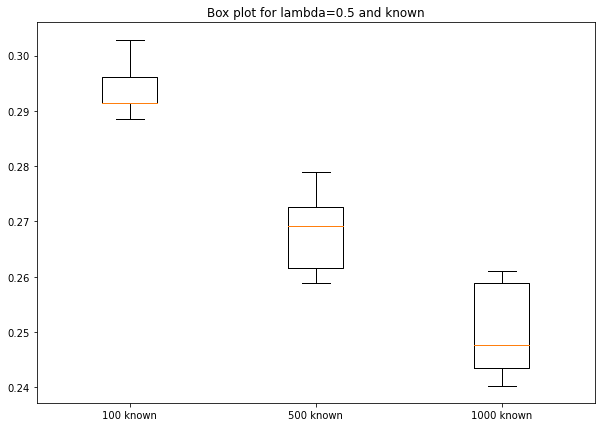

In [ ]:
# Creating dataset
np.random.seed(10)
data = [bo_100 , bo_500, bo_1000]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

ax.set_xticklabels(['100 known', '500 known','1000 known'])
 
# Creating plot
plt.boxplot(data)
plt.title("Box plot for lambda=0.5 and known") 
# show plot
plt.show()

##### Distributional smoothing techniques with known=100

In [ ]:
class language_model(language_model):
  def _make_unknowns(self,known=100):
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1

        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
            else:
                self.bigram[k]=adict

        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            for word in k:
              isknown=self.unigram.get(word,0)
              if isknown==0:
                del self.trigram[k]
                k = list(k)
                k[k.index(word)] = "__UNK"
                k = tuple(k)
                current=self.trigram.get(k,{})
                current.update(adict)
                self.trigram[k]=current
              else:
                self.trigram[k]=adict

In [ ]:
class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="distributional",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="distributional",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="distributional",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="distributional",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

In [ ]:
lm = language_model(trainingdir=trainingdir,files=training)

In [ ]:
#Distributional smoothing bigram
SCC_test = scc_reader()
distri_bi = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="bigram",lm=lm)
  print(acc)
  distri_bi.append(acc)


print("Score for quadrigram",sum(distri_bi)/len(distri_bi))

In [ ]:
#Distributional smoothing trigram
SCC_test = scc_reader()
distri_tri = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="trigram",lm=lm)
  print(acc)
  distri_tri.append(acc)


print("Score for quadrigram",sum(distri_tri)/len(distri_tri))

In [ ]:
#Distributional smoothing quadrigram
SCC_test = scc_reader()
distri_quad = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  distri_quad.append(acc)


print("Score for quadrigram",sum(distri_quad)/len(distri_quad))

##### Back-Off smoothing techniques with known=100

In [ ]:
class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="back_off",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="back_off",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="back_off",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="back_off",lmbda=0.5) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

In [ ]:
#Back Off smoothing bigram
SCC_test = scc_reader()
back_bi = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="bigram",lm=lm)
  print(acc)
  back_bi.append(acc)


print("Score for quadrigram",sum(back_bi)/len(back_bi))

In [ ]:
#Back Off smoothing trigram
SCC_test = scc_reader()
back_tri = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="trigram",lm=lm)
  print(acc)
  back_tri.append(acc)


print("Score for quadrigram",sum(back_tri)/len(back_tri))

In [ ]:
#Back Off smoothing quadrigram
SCC_test = scc_reader()
back_quad = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  back_quad.append(acc)


print("Score for quadrigram",sum(back_quad)/len(back_quad))

Both smoothing techniques with known=100 and lambda=0.2

In [ ]:
class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

In [ ]:
SCC_test = scc_reader()
quadri_average_0_02 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  quadri_average_0_02.append(acc)

print("Score for quadrigram",sum(quadri_average_0_02)/len(quadri_average_0_02))

Both smoothing techniques with known=100 and lambda=1

In [ ]:
class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

In [ ]:
SCC_test = scc_reader()
quadri_average_0_1 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  quadri_average_0_1.append(acc)


print("Score for quadrigram",sum(quadri_average_0_1)/len(quadri_average_0_1))

Both smoothing techniques with known=500 and lambda=0.2

In [ ]:
class language_model(language_model):
  def _make_unknowns(self,known=500):
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1

        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
            else:
                self.bigram[k]=adict

        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            for word in k:
              isknown=self.unigram.get(word,0)
              if isknown==0:
                del self.trigram[k]
                k = list(k)
                k[k.index(word)] = "__UNK"
                k = tuple(k)
                current=self.trigram.get(k,{})
                current.update(adict)
                self.trigram[k]=current
              else:
                self.trigram[k]=adict

class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

In [ ]:
lm = language_model(trainingdir=trainingdir,files=training)

In [ ]:
SCC_test = scc_reader()
quadri_average_200_02 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  quadri_average_200_02.append(acc)


print("Score for quadrigram",sum(quadri_average_200_02)/len(quadri_average_200_02))

Both smoothing techniques with known=500 and lambda=1

In [ ]:
class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

In [ ]:
SCC_test = scc_reader()
quadri_average_500_1 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  quadri_average_500_1.append(acc)

print("Score for quadrigram",sum(quadri_average_500_1)/len(quadri_average_500_1))

Both smoothing techniques with known=1000 and lambda=0.2

In [ ]:
class language_model(language_model):
  def _make_unknowns(self,known=1000):
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1

        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
            else:
                self.bigram[k]=adict

        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            for word in k:
              isknown=self.unigram.get(word,0)
              if isknown==0:
                del self.trigram[k]
                k = list(k)
                k[k.index(word)] = "__UNK"
                k = tuple(k)
                current=self.trigram.get(k,{})
                current.update(adict)
                self.trigram[k]=current
              else:
                self.trigram[k]=adict

class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="both",lmbda=0.2) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

In [ ]:
lm = language_model(trainingdir=trainingdir,files=training)

In [ ]:
SCC_test = scc_reader()
quadri_average_1000_02 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  quadri_average_1000_02.append(acc)

print("Score for quadrigram",sum(quadri_average_1000_02)/len(quadri_average_1000_02))

Both smoothing techniques with known=1000 and lambda=1

In [ ]:
class question(question):
    def chooseunigram(self,lm):
        choices=["a","b","c","d","e"]      
        probs=[lm.get_prob(self.get_field(ch+")"),0,methodparams={"method":"unigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
        
    def choosebigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"bigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosetrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"trigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

    def choosequadrigram(self,lm,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        context=self.get_left_context(window=3)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":"quadrigram"},smoothing="both",lmbda=1) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)

In [ ]:
SCC_test = scc_reader()
quadri_average_1000_1 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="quadrigram",lm=lm)
  print(acc)
  quadri_average_1000_1.append(acc)

print("Score for quadrigram",sum(quadri_average_1000_1)/len(quadri_average_1000_1))

### Recurrent Neural Network Language Model

##### Create quadrigram and word embeddings

In [ ]:
def create_quadrigram_set(files,training_dir):
  alltokens=["__END"]
  start=False
  for afile in files:
    print("Processing {}".format(afile))
    try:
      with open(os.path.join(training_dir,afile)) as instream:
        for line in instream:
          line=line.rstrip()
          if len(line)>0 and start:
            if "end of project gutenberg" not in line.lower() and "end of the project gutenberg" not in line.lower():
              tokens=["__END","__START"]+tokenize(line)+["__END"]
              alltokens+=tokens
          if "*END*" in line:
            start = True
      start = False
    except UnicodeDecodeError:
      print("UnicodeDecodeError processing {}: ignoring file".format(afile))
  
  vocab={}
  threshold=20
  for token in alltokens:
    vocab[token]=vocab.get(token,0)+1
  unknowns=0
  for key,value in list(vocab.items()):
    if value < threshold:
      unknowns+=value
      vocab.pop(key,None)
  vocab["__UNK"]=unknowns

  word_to_ix = {word: i for i, word in enumerate(list(vocab.keys()))}
  ix_to_word = {i: word for i, word in enumerate(list(vocab.keys()))}

  filteredtokens=[]
  for token in alltokens:
    if token in vocab.keys():
      filteredtokens.append(token)
    else:
      filteredtokens.append("__UNK")
  quadrigrams = [([filteredtokens[i], filteredtokens[i + 1], filteredtokens[i + 2]], filteredtokens[i + 3])
        for i in range(len(filteredtokens) - 3)]
  return quadrigrams, vocab, word_to_ix, ix_to_word

QUADRIGRAM, VOCAB, WORD_TO_IX, IX_TO_WORD = create_quadrigram_set(files=training,training_dir=trainingdir)

##### Creating Neural Language Model class

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available() 

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used") 

CONTEXT_SIZE = 3
EMBEDDING_DIM = 1000

class NGramRecurrentLanguageModeler(nn.Module):
  def __init__(self, input_size, embedding_dim,hidden_size, output_size, n_layers):
        super(NGramRecurrentLanguageModeler, self).__init__()

        # Defining some parameters
        self.embeddings = nn.Embedding(output_size, embedding_dim)
        self.hidden_size=hidden_size
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, bidirectional=True, num_layers=n_layers, batch_first=True)   #, bidirectional=True, num_layers=n_layers, batch_first=True
        # Fully connected layer
        self.fc = nn.Linear(self.hidden_size*2, output_size) #output_shape 3

  def forward(self, x):
        embeds = self.embeddings(x)
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)  
        c0 = self.init_hidden(batch_size) 

        # Passing in the input and hidden state into the model and obtaining outputs
        x = x.view(*x.shape[:1], -1, *x.shape[3:])
        embeds = embeds.view(*embeds.shape[:1], -1, *embeds.shape[3:])
        out,_= self.rnn(embeds.unsqueeze(1),(hidden,c0)) #,hidden   embeds.view(len(x)
        
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.reshape(out.shape[0],-1)  #out.contiguous().view(-1, len(VOCAB)) 
        out = self.fc(out)
        
        return out  # , hidden 

  def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers*2, batch_size, self.hidden_size).to(device)
        return hidden

##### Training

In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM,hidden_size=128, output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

x_train = []
y_train = []

for context, target in QUADRIGRAM:

  x_train.append([WORD_TO_IX[w] for w in context])

  y_train.append([WORD_TO_IX[target]])      


x_train = torch.tensor(x_train,dtype=torch.long).to(device)
y_train = torch.tensor(y_train,dtype=torch.long).to(device)

  

class WordToIxDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    _x = self.X[index]
    _y = self.Y[index]
    return _x, _y

loader = DataLoader(WordToIxDataset(x_train, y_train), batch_size=8192, shuffle=True, num_workers=0)
print('Training set has {} instances'.format(len(loader)))

In [ ]:
train_loader_iter = iter(loader)
imgs, labels = next(train_loader_iter)
print(imgs.shape)

print(labels.shape)

torch.Size([8192, 3])
torch.Size([8192, 1])


In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM, hidden_size=128,output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

# Define hyperparameters
n_epochs = 25
lr=0.01

# Define Loss, Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nLanguageModel.parameters(), lr=lr)

losses_001=[]
running_loss = 0.
last_loss = 0.

# Training Run
for epoch in range(1, n_epochs + 1):
  total_loss = 0
  for i, (context_x, target_y) in enumerate(loader):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output = nLanguageModel(context_x.to(device)) #, hidden
    
    loss = loss_function(output, target_y.flatten().to(device))
    del output
    torch.cuda.empty_cache()

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch * len(loader) + i + 1
      print('Loss/train', last_loss, tb_x)
      running_loss = 0. 

    total_loss += loss.item()
  losses_001.append(total_loss)
  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(losses_001)

In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM, hidden_size=128,output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

# Define hyperparameters
n_epochs = 25
lr=0.001

# Define Loss, Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nLanguageModel.parameters(), lr=lr)

losses_0001=[]
running_loss = 0.
last_loss = 0.

# Training Run
for epoch in range(1, n_epochs + 1):
  total_loss = 0
  for i, (context_x, target_y) in enumerate(loader):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output = nLanguageModel(context_x.to(device)) #, hidden
    
    loss = loss_function(output, target_y.flatten().to(device))
    del output
    torch.cuda.empty_cache()

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch * len(loader) + i + 1
      print('Loss/train', last_loss, tb_x)
      running_loss = 0. 

    total_loss += loss.item()
  losses_0001.append(total_loss)
  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(losses_0001)

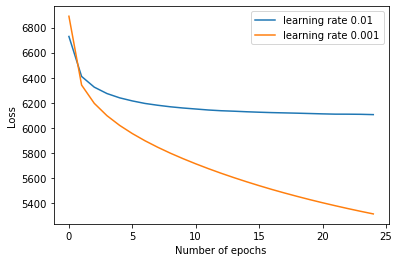

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses_001, label='learning rate 0.01')
plt.plot(losses_0001, label='learning rate 0.001')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

##### Testing

In [ ]:
def get_logprob(context,target):
  #return the logprob of the target word given the context
  w_in_contxt=[]
  for w in context:
    if w in WORD_TO_IX.keys():
      w_in_contxt.append(WORD_TO_IX[w])
    else:
      w_in_contxt.append(WORD_TO_IX["__UNK"])
  context_idxs = torch.tensor(w_in_contxt, dtype=torch.long)     
  context_idxs = context_idxs[None,:]
  log_probs= nLanguageModel.forward(context_idxs.to(device))
  if target not in WORD_TO_IX.keys():
    target_idx=torch.tensor(WORD_TO_IX["__UNK"])
  else:
    target_idx=torch.tensor(WORD_TO_IX[target])
  return log_probs.index_select(1,target_idx.to(device)).item()

class question(question):
    def choosenmodel(self):
        choices=["a","b","c","d","e"]  
        context=self.get_left_context(window=3)    
        probs=[get_logprob(context=context,target=self.get_field(ch+")")) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
        
    def predict(self,lm,method):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        elif method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram":
            return self.choosebigram(lm=lm)
        elif method=="trigram":
            return self.choosetrigram(lm=lm)
        elif method=="quadrigram":
          return self.choosequadrigram(lm=lm)
        elif method=="nmodel":
          return self.choosenmodel()

In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM, hidden_size=32,output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

# Define hyperparameters
n_epochs = 25
lr=0.001

# Define Loss, Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nLanguageModel.parameters(), lr=lr)

losses_0001=[]
running_loss = 0.
last_loss = 0.

# Training Run
for epoch in range(1, n_epochs + 1):
  total_loss = 0
  for i, (context_x, target_y) in enumerate(loader):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output = nLanguageModel(context_x.to(device)) #, hidden
    
    loss = loss_function(output, target_y.flatten().to(device))
    del output
    torch.cuda.empty_cache()

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch * len(loader) + i + 1
      print('Loss/train', last_loss, tb_x)
      running_loss = 0. 

    total_loss += loss.item()
  losses_0001.append(total_loss)
  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(losses_0001)

In [ ]:
SCC_test = scc_reader()
lm=None

nn_0001_32 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="nmodel",lm=lm)
  print(acc)
  nn_0001_32.append(acc)


print("Score for quadrigram",sum(nn_0001_32)/len(nn_0001_32))

In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM, hidden_size=32,output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

# Define hyperparameters
n_epochs = 25
lr=0.01

# Define Loss, Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nLanguageModel.parameters(), lr=lr)

losses_0001=[]
running_loss = 0.
last_loss = 0.

# Training Run
for epoch in range(1, n_epochs + 1):
  total_loss = 0
  for i, (context_x, target_y) in enumerate(loader):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output = nLanguageModel(context_x.to(device)) #, hidden
    
    loss = loss_function(output, target_y.flatten().to(device))
    del output
    torch.cuda.empty_cache()

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch * len(loader) + i + 1
      print('Loss/train', last_loss, tb_x)
      running_loss = 0. 

    total_loss += loss.item()
  losses_0001.append(total_loss)
  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(losses_0001)

In [ ]:
SCC_test = scc_reader()
lm=None

nn_001_32 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="nmodel",lm=lm)
  print(acc)
  nn_001_32.append(acc)


print("Score for quadrigram",sum(nn_001_32)/len(nn_001_32))

In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM, hidden_size=128,output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

# Define hyperparameters
n_epochs = 25
lr=0.001

# Define Loss, Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nLanguageModel.parameters(), lr=lr)

losses_0001=[]
running_loss = 0.
last_loss = 0.

# Training Run
for epoch in range(1, n_epochs + 1):
  total_loss = 0
  for i, (context_x, target_y) in enumerate(loader):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output = nLanguageModel(context_x.to(device)) #, hidden
    
    loss = loss_function(output, target_y.flatten().to(device))
    del output
    torch.cuda.empty_cache()

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch * len(loader) + i + 1
      print('Loss/train', last_loss, tb_x)
      running_loss = 0. 

    total_loss += loss.item()
  losses_0001.append(total_loss)
  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(losses_0001)

In [ ]:
SCC_test = scc_reader()
lm=None

nn_0001_128 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="nmodel",lm=lm)
  print(acc)
  nn_0001_128.append(acc)


print("Score for quadrigram",sum(nn_0001_128)/len(nn_0001_128))

In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM, hidden_size=128,output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

# Define hyperparameters
n_epochs = 25
lr=0.01

# Define Loss, Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nLanguageModel.parameters(), lr=lr)

losses_0001=[]
running_loss = 0.
last_loss = 0.

# Training Run
for epoch in range(1, n_epochs + 1):
  total_loss = 0
  for i, (context_x, target_y) in enumerate(loader):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output = nLanguageModel(context_x.to(device)) #, hidden
    
    loss = loss_function(output, target_y.flatten().to(device))
    del output
    torch.cuda.empty_cache()

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch * len(loader) + i + 1
      print('Loss/train', last_loss, tb_x)
      running_loss = 0. 

    total_loss += loss.item()
  losses_0001.append(total_loss)
  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(losses_0001)

In [ ]:
SCC_test = scc_reader()
lm=None

nn_001_128 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="nmodel",lm=lm)
  print(acc)
  nn_001_128.append(acc)


print("Score for quadrigram",sum(nn_001_128)/len(nn_001_128))

In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM, hidden_size=256,output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

# Define hyperparameters
n_epochs = 25
lr=0.001

# Define Loss, Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nLanguageModel.parameters(), lr=lr)

losses_0001=[]
running_loss = 0.
last_loss = 0.

# Training Run
for epoch in range(1, n_epochs + 1):
  total_loss = 0
  for i, (context_x, target_y) in enumerate(loader):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output = nLanguageModel(context_x.to(device)) #, hidden
    
    loss = loss_function(output, target_y.flatten().to(device))
    del output
    torch.cuda.empty_cache()

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch * len(loader) + i + 1
      print('Loss/train', last_loss, tb_x)
      running_loss = 0. 

    total_loss += loss.item()
  losses_0001.append(total_loss)
  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(losses_0001)

In [ ]:
SCC_test = scc_reader()
lm=None

nn_0001_256 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="nmodel",lm=lm)
  print(acc)
  nn_0001_256.append(acc)


print("Score for quadrigram",sum(nn_0001_256)/len(nn_0001_256))

In [ ]:
from torch._C import dtype
# Instantiate the model with hyperparameters
nLanguageModel = NGramRecurrentLanguageModeler(input_size=CONTEXT_SIZE*EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM, hidden_size=256,output_size=len(VOCAB), n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
nLanguageModel.to(device)

# Define hyperparameters
n_epochs = 25
lr=0.01

# Define Loss, Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nLanguageModel.parameters(), lr=lr)

losses_001=[]
running_loss = 0.
last_loss = 0.

# Training Run
for epoch in range(1, n_epochs + 1):
  total_loss = 0
  for i, (context_x, target_y) in enumerate(loader):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output = nLanguageModel(context_x.to(device)) #, hidden
    
    loss = loss_function(output, target_y.flatten().to(device))
    del output
    torch.cuda.empty_cache()

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch * len(loader) + i + 1
      print('Loss/train', last_loss, tb_x)
      running_loss = 0. 

    total_loss += loss.item()
  losses_001.append(total_loss)
  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(losses_001)

In [ ]:
SCC_test = scc_reader()
lm=None

nn_001_256 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="nmodel",lm=lm)
  print(acc)
  nn_001_256.append(acc)


print("Score for quadrigram",sum(nn_001_256)/len(nn_001_256))

# Failure cases

In [ ]:
SCC = scc_reader()
SCC.predict_and_score(method="quadrigram",lm=lm)

In [ ]:
nLanguageModel.to(device)
SCC_test = scc_reader()
lm=None

n0n_001_4 = []
for i in range(10):
  acc = SCC_test.predict_and_score(method="nmodel",lm=lm)
  print(acc)
  n0n_001_4.append(acc)


print("Score for quadrigram",sum(n0n_001_4)/len(n0n_001_4))

In [ ]:
pd.options.display.max_colwidth = 500
questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

#Visualise the sentences and their possibilities 
with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_model_df=pd.DataFrame(lines[1:],columns=lines[0])

#Visualise the answers to complete the sentence
with open(answers) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)


qs_model_df["answers"] = lines[1:]
qs_model_df["quadrigram_pred"]=SCC.predict(method="quadrigram",lm=lm)
qs_df["RNN_pred"]=SCC.predict(method="nmodel",lm=None) 
qs_model_df

,id,question,a),b),c),d),e),answers,quadrigram_pred
0,1,I have it from the same source that you are both an orphan and a bachelor and are _____ alone in London.,crying,instantaneously,residing,matched,walking,"[1, c]",b
1,2,"It was furnished partly as a sitting and partly as a bedroom , with flowers arranged _____ in every nook and corner.",daintily,privately,inadvertently,miserably,comfortably,"[2, a]",e
2,3,"As I descended , my old ally , the _____ , came out of the room and closed the door tightly behind him.",gods,moon,panther,guard,country-dance,"[3, d]",b
3,4,"We got off , _____ our fare , and the trap rattled back on its way to Leatherhead.",rubbing,doubling,paid,naming,carrying,"[4, c]",e
4,5,"He held in his hand a _____ of blue paper , scrawled over with notes and figures.",supply,parcel,sign,sheet,chorus,"[5, d]",e
...,...,...,...,...,...,...,...,...,...
1035,1036,"The bedrooms in this _____ are on the ground floor , the sitting-rooms being in the central block of the buildings.",wing,coach,balcony,kingdom,neighbourhood,"[1036, a]",d
1036,1037,"Our visitor bore every mark of being an average commonplace British tradesman , obese , _____ , and slow.",blind,energetic,eloquent,pompous,sandy-haired,"[1037, d]",a
1037,1038,"The terror of his face lay in his eyes , however , steel gray , and glistening coldly with a malignant , inexorable _____ in their depths.",cruelty,novitiate,justice,broker,success,"[1038, a]",a
1038,1039,"It is your commonplace , _____ crimes which are really puzzling , just as a commonplace face is the most difficult to identify.",underlying,featureless,theological,flattering,inevitable,"[1039, b]",c


In [ ]:
SCC = scc_reader()
qs_model_df["RNN_pred"]=SCC.predict(method="nmodel",lm=None) 


In [ ]:
qs_model_df.loc[51:100]

,id,question,a),b),c),d),e),answers,quadrigram_pred,RNN_pred
51,52,It was one of the main arteries which _____ the traffic of the City to the north and west.,supported,surrounded,sheltered,conveyed,contained,"[52, d]",e,b
52,53,"I stooped in some confusion and began to pick up the fruit , understanding for some reason my companion desired me to take the _____ upon myself.",oath,message,blame,shirt,shadows,"[53, c]",b,e
53,54,"He had a very dark , _____ face , and a gleam in his eyes that comes back to me in my dreams.",rosy,childish,fearsome,colorless,yellow,"[54, c]",d,e
54,55,"The fat man _____ his eyes round , and then up at the open skylight.",cast,folded,hastened,jingled,winked,"[55, a]",e,c
55,56,"We passed up the stair , _____ the door , followed on down a passage , and found ourselves in front of the barricade which Miss Hunter had described.",devoured,translated,unlocked,ascended,occupied,"[56, c]",b,a
56,57,Holmes was for the moment as _____ as I. His hand closed like a vice upon my wrist in his agitation.,startled,tired,thin,wise,clever,"[57, a]",d,c
57,58,"The chimney is wide , but is _____ up by four large staples.",torn,softened,higher,barred,constantly,"[58, d]",a,a
58,59,"My companion sat in the front of the trap , his arms folded , his hat _____ down over his eyes , and his chin sunk upon his breast , buried in the deepest thought.",closed,slouched,wheeled,pulled,blown,"[59, d]",d,e
59,60,"He used to make _____ over the cleverness of women , but I have not heard him do it of late.",progress,matters,merry,advances,rules,"[60, c]",c,e
60,61,"I have _____ , therefore , to call upon you and to consult you in reference to the very painful event which has occurred in connection with my wedding.",determined,related,overheard,absconded,noticed,"[61, a]",e,d
